In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import json
import argparse
import copy

import h5py

from matplotlib.colors import LogNorm

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)
hlittle = cosmo.H0.value / 100

from astropy import units as u

from lightcone_utils import load_data, show_map, plot_mean

### Load data
base_dir = "../dataset/generated_data_lightcone"
output_dir = "{}/figures".format(base_dir)
os.makedirs(output_dir, exist_ok=True)

from line_model import line_dict 
line_names = list(line_dict.keys())
NLINE = len(line_names)

# Load ../dataset/generated_data_lightcone/pinocchio.run.3600sec_fmin248_fmax301_R500.h5
Total intensity CO(4-3): 9.680131e+07
Total intensity CO(5-4): 5.032906e+07
Total intensity CO(6-5): 4.501150e+07
Total intensity CO(7-6): 2.803872e+07
Total intensity CO(8-7): 2.238068e+07
Total intensity CO(9-8): 1.912795e+07
Total intensity CO(10-9): 9.576748e+06
Total intensity CO(11-10): 7.361790e+06
Total intensity CO(12-11): 3.684896e+06
Total intensity CO(13-12): 1.422626e+05
Total intensity [CII]158: 9.863543e+06
Total intensity [CI](1-0): 5.630950e+07
Total intensity [CI](2-1): 2.422125e+07
freqency shape:  (96,)
intensity shape:  (120, 120, 95)
Projection along y-axis: 120 slices


/mnt/data/moriwaki/lim-mock-generator/scripts_lightcone/lightcone_utils.py:405: RuntimeWarning: divide by zero encountered in log10
  if log_scale: map_xz = np.log10(map_xz)
/mnt/data/moriwaki/lim-mock-generator/scripts_lightcone/lightcone_utils.py:405: RuntimeWarning: divide by zero encountered in log10
  if log_scale: map_xz = np.log10(map_xz)
/mnt/data/moriwaki/lim-mock-generator/scripts_lightcone/lightcone_utils.py:405: RuntimeWarning: divide by zero encountered in log10
  if log_scale: map_xz = np.log10(map_xz)
/mnt/data/moriwaki/lim-mock-generator/scripts_lightcone/lightcone_utils.py:405: RuntimeWarning: divide by zero encountered in log10
  if log_scale: map_xz = np.log10(map_xz)
/mnt/data/moriwaki/lim-mock-generator/scripts_lightcone/lightcone_utils.py:405: RuntimeWarning: divide by zero encountered in log10
  if log_scale: map_xz = np.log10(map_xz)
/mnt/data/moriwaki/lim-mock-generator/scripts_lightcone/lightcone_utils.py:405: RuntimeWarning: divide by zero encountered in log1

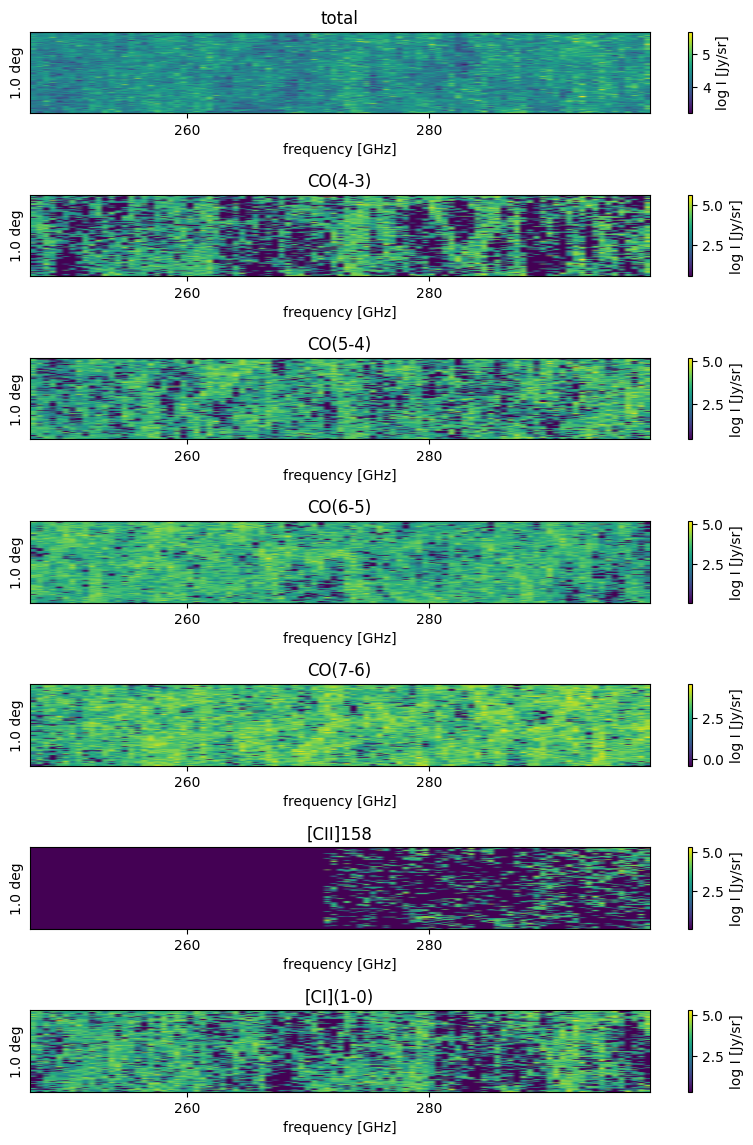

In [3]:
fname = "{}/pinocchio.run.3600sec_fmin248_fmax301_R500.h5".format(base_dir)
freq, intensity, intensity_line, attrs = load_data(fname)
side_length = attrs['side_length']
lines_to_show = ["CO(2-1)", "CO(3-2)", "CO(4-3)", "CO(5-4)", "CO(6-5)", "CO(7-6)", "[CII]158", "[CI](1-0)"]
show_map(freq, intensity, intensity_line, side_length, dy=-1, lines_to_show=lines_to_show, log_scale=True)

# Load ../dataset/generated_data_lightcone/pinocchio.run.3600sec_fmin100_fmax1000_R20.h5
Total intensity CO(2-1): 7.407501e+06
Total intensity CO(3-2): 2.841216e+07
Total intensity CO(4-3): 1.613203e+07
Total intensity CO(5-4): 1.386954e+07
Total intensity CO(6-5): 1.030877e+07
Total intensity CO(7-6): 7.414688e+06
Total intensity CO(8-7): 7.340182e+06
Total intensity CO(9-8): 5.805938e+06
Total intensity CO(10-9): 4.358628e+06
Total intensity CO(11-10): 3.976990e+06
Total intensity CO(12-11): 2.637496e+06
Total intensity CO(13-12): 1.661081e+05
Total intensity [CII]158: 1.227366e+08
Total intensity [CI](1-0): 1.040260e+07
Total intensity [CI](2-1): 6.553162e+06
freqency shape:  (47,)
intensity shape:  (120, 120, 46)


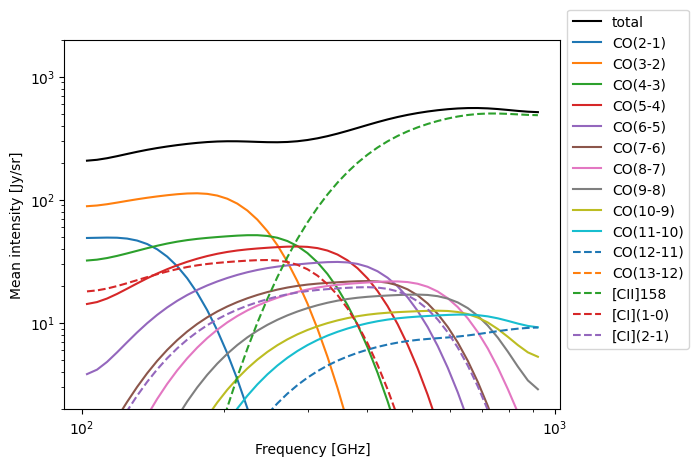

In [7]:
fname = "{}/pinocchio.run.3600sec_fmin100_fmax1000_R20.h5".format(base_dir)
freq, intensity, intensity_line, attrs = load_data(fname)
side_length = attrs['side_length']
plot_mean(freq, intensity, intensity_line, logx=True, nsmooth=4, ylim=(2, 2e3))